$\textbf{Repeat two methods of optimization of GAN: using eq 1 and alternative method for better gradients}$

Чтобы узнать распределение генератора $p_g$ по данным $x$, мы определяем априорные переменные входного шума $p_z(z)$, затем представляем отображение в пространство данных как $G(z; \theta_g)$, где G - дифференцируемая функция с параметрами $\theta_g$. Мы также определяем $D(x; \theta_d)$, который выводит один скаляр. $D(x)$ представляет вероятность того, что $x$ получено из данных, а не из $p_g$. Мы обучаем $D$, чтобы максимизировать вероятность присвоения исправьте метку как для обучающих примеров, так и для образцов из $G$.
Другими словами, $D$ и $G$ играют в следующую минимаксную игру для двух игроков с функцией значений $V (G, D)$:
$$
\large{
\underset{G}{\min} \underset{D}{\max} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
}
$$
Оптимизация $D$ до завершения во внутреннем цикле обучения требует больших вычислительных затрат, а на конечных наборах данных привела бы к переобучению. Вместо этого в статье предлагается чередовать k шагов оптимизации $D$ и один шаг оптимизации $G$, потому что $D$ будет вблизи своего оптимального решения, пока $G$ изменяется достаточно медленно.
На ранних этапах обучения, когда $G$ является плохим, $D$ может отклонять выборки с высокой степенью достоверности, поскольку они явно отличаются от обучающих данных. Вместо обучения $G$, чтобы минимизировать $\log(1 − D(G(z)))$ мы можем обучить $G$ максимизировать $\log D(G(z))$. Эта целевая функция приводит к одной и той же фиксированной точке динамики G и D, но обеспечивает гораздо более сильные градиенты на ранних этапах обучения.

Вопрос: почему мы минимизируем функцию потерь?

In [1]:
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass

import os
from functools import partial
import jax
import optax
import jax.numpy as jnp
from typing import Any, Tuple
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.nn.initializers import normal as normal_init
from flax.training import train_state
from flax import linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from flax.training.common_utils import shard, shard_prng_key

In [2]:
arr = jnp.arange(10)

In [3]:
device = arr.device()
device.platform, device.device_kind

('gpu', 'Tesla T4')

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
### функция для отрисовки
def plot_samples_and_losses(gen_loss, disc_loss, sample):
  plt.plot(disc_loss, label='discriminator loss')
  plt.plot(gen_loss, label='generator loss')
  plt.legend()
  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
  for ax, image in zip(sum(axes.tolist(), []), sample):
    ax.imshow(image, cmap='gray')
    ax.set_axis_off()
  plt.show()

In [6]:
# инициализация гиперпараметров
PRNGKey = jnp.ndarray
#num_devices = jax.device_count()
args = {'z_dim': 64, 'seed': 41}
args['batch_size'] = 256 #num_devices * 256 if num_devices > 1 else 256
args['epochs'] = 21
#args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size'], 1), dtype=jnp.int32)

In [7]:
jax.device_count()

1

In [8]:
# подгрузка данных
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5
  return batch


mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // args['batch_size']

data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=args['seed'])
        .repeat()
        .batch(args['batch_size'])
 ))

## GAN

In [9]:
class TrainState(train_state.TrainState):
  batch_stats: Any
class Generator(nn.Module):
  features: int = 64
  dtype: type = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):
    conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                             kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    z = z.reshape((args['batch_size'], 1, 1, args['z_dim']))
    x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*3, kernel_size=[4, 4], strides=[1, 1])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(1, [4, 4], [2, 2])(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = 64
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):
    conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                   kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    x = conv(self.features)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(self.features*2)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(1)(x)
    x = x.reshape((args['batch_size'], -1))
    return x


@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape):
  model = model_cls()

  tx = optax.adam(0.0002, b1=0.5, b2=0.999)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx,
      params=variables['params'], batch_stats=variables['batch_stats'])
  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params,
       'batch_stats': generator_state.batch_stats},
      input_noise, train=False, mutable=False)
  return generated_data

## Loss Function

In [15]:
@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):

  input_noise = jax.random.normal(key, (args['batch_size'], args['z_dim']))

  def loss_fn_min(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params,
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])

    loss = jnp.mean(jnp.log(1 - logits)) #jnp.mean(jnp.log(nn.sigmoid(logits))) #jnp.mean(jnp.log(1 - nn.sigmoid(logits))) #jnp.mean(jnp.log(1 - logits))
    return loss, mutables

  def loss_fn_max(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params,
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])
    # generated_loss = optax.sigmoid_binary_cross_entropy(
    #     logits, args['false_label']).mean()

    loss = jnp.mean(jnp.log(1 - nn.sigmoid(logits)))  #-jnp.mean(jnp.log(nn.sigmoid(logits)))
    return loss, mutables

  grad_fn = jax.value_and_grad(loss_fn_max, has_aux=True)
  (loss, mutables), grads = grad_fn(generator_state.params)

  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  new_generator_state = generator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])

  return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):

  input_noise = jax.random.normal(key, (args['batch_size'], args['z_dim']))

  generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
         input_noise, mutable=['batch_stats'])

  def loss_fn(params):
    logits_real, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': discriminator_state.batch_stats},
        real_data, mutable=['batch_stats'])

    logits_generated, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': mutables['batch_stats']},
        generated_data, mutable=['batch_stats'])

    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label']).mean()
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits_generated, args['false_label']).mean()

    loss = (real_loss + generated_loss) / 2

    return loss, mutables

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(discriminator_state.params)

  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')


  new_discriminator_state = discriminator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])

  return new_discriminator_state, loss

## Training

In [16]:
def main():
  """
  init params
  """
  key = jax.random.PRNGKey(seed=args['seed'])
  key_generator, key_discriminator, key = jax.random.split(key, 3)
  key_generator = shard_prng_key(key_generator)
  key_discriminator = shard_prng_key(key_discriminator)

  discriminator_state = create_state(key_discriminator, Discriminator,
      (args['batch_size'], *next(data_gen).shape[1:]))

  generator_state = create_state(key_generator, Generator,
      (args['batch_size'], args['z_dim']))

  generator_input = jax.random.normal(key, (args['batch_size'], args['z_dim']))
  generator_input = shard(generator_input)
  """
  train model and generate
  """
  disc_loss = []
  gen_loss = []
  for epoch in tqdm(range(1, args['epochs'] + 1), desc="Epoch",
                    position=0, leave=True):

    with tqdm(total=batches_in_epoch, desc="Train model", leave=False) as progress_bar_train:
      for batch in range(batches_in_epoch):
        key, key_generator, key_discriminator = jax.random.split(key, 3)
        key_generator = shard_prng_key(key_generator)
        key_discriminator = shard_prng_key(key_discriminator)
        batch_data = shard(next(data_gen))
        generator_state, generator_loss = generator_step(generator_state,
            discriminator_state, key_generator)
        discriminator_state, discriminator_loss = discriminator_step(
            generator_state, discriminator_state, batch_data, key_discriminator)

        progress_bar_train.update(1)

        disc_loss.append(discriminator_loss)
        gen_loss.append(generator_loss)

  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1, 28, 28))
  return gen_loss, disc_loss, sample

$\textbf{Стандартный способ тренировки генератора G}$

In [35]:
## argmin log 1 - D(G)

In [17]:
args['epochs'] = 21

In [18]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

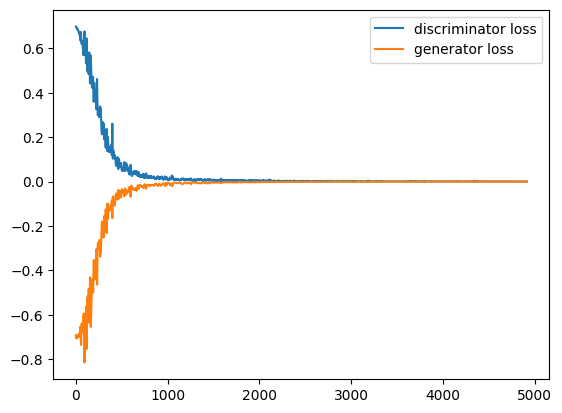

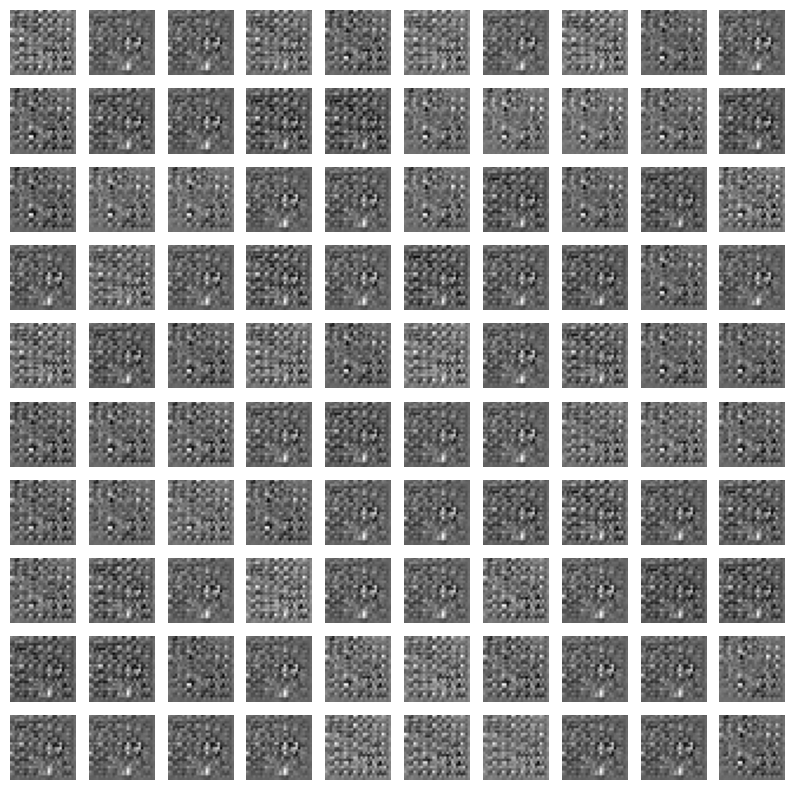

In [19]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

In [31]:
## argmax log D(G)

In [32]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

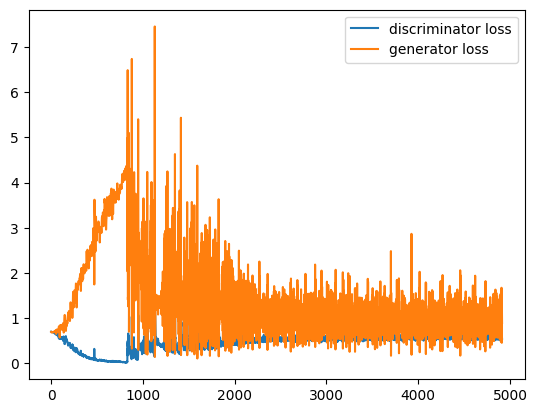

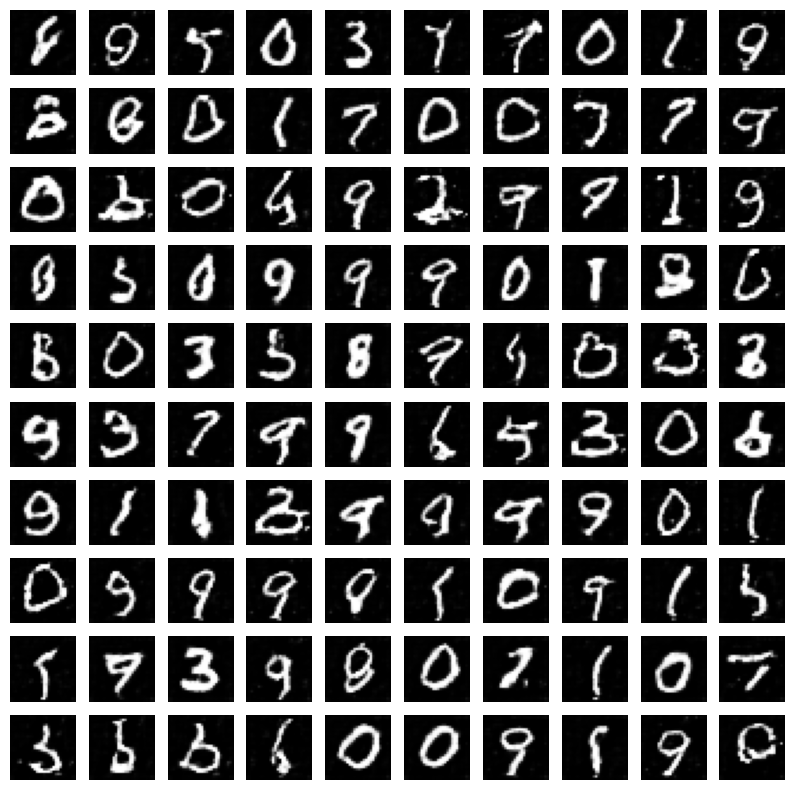

In [33]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

In [ ]:
# наблюдаем, что со вторым лоссом модель сошлась быстрее и качество генерации намного выше,
#если рассматривать 21 эпоху, что получается уже экономит наши вычислительные возможности

$\textbf{Алтернативный способ тренировки генератора G}$

In [ ]:
# нужно перезапусть ячейки, начиная с определения лоссов, поставив в лоссе генератора функцию loss_fn_min, бинарная перекрестная потеря энтропии без отрицательного знака в начале

In [53]:
args['epochs'] = 21

In [54]:
## argmin log D(G)

In [55]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

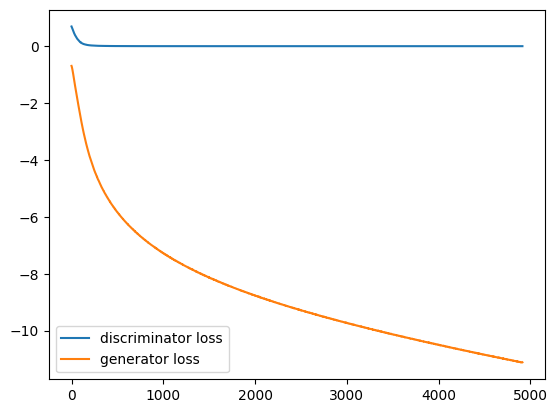

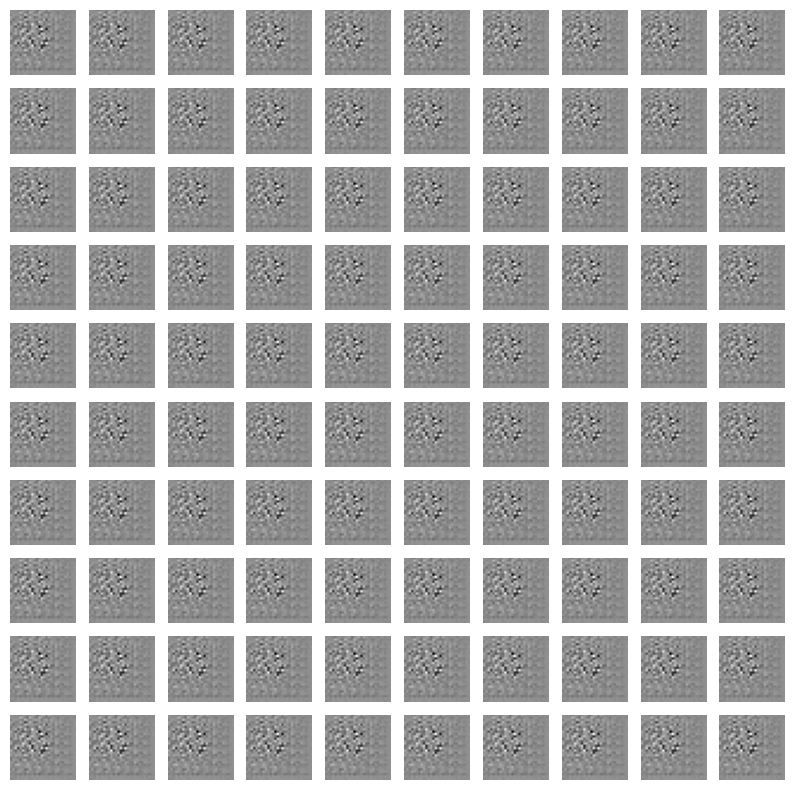

In [56]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

In [59]:
## argmax 1 - log D(G)

In [60]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

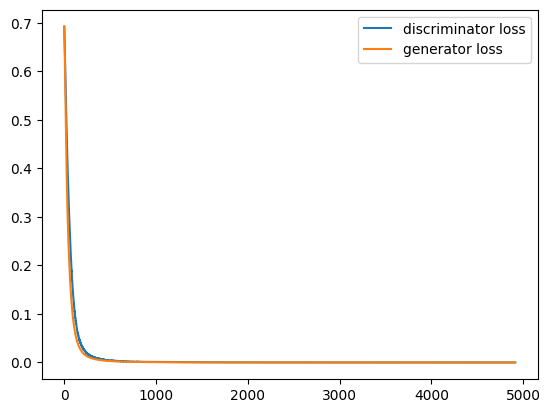

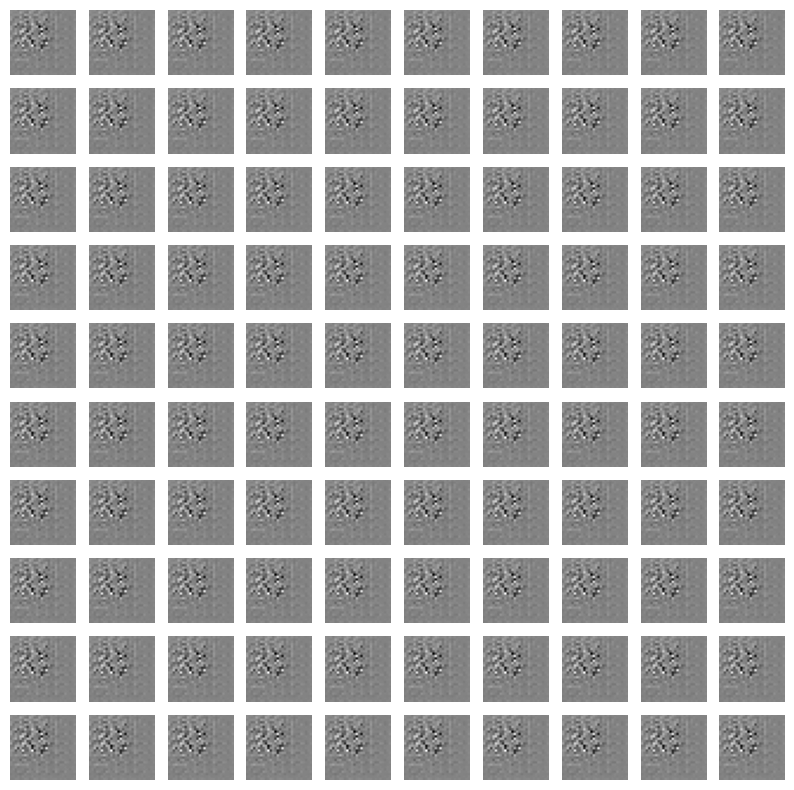

In [61]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

In [ ]:
## видно, что замена минимизации на максимизацию двух случаях все ломает

Нам интересно сравнение лоссов максимизации log(D(G)) и минимизация 1 - log(D(G)). Исходя из результатов можно сделать вывод, что во втором случае у нас медленная сходимость и качество семлов оставляет желать лучшего, но при росте количества эпох обучения качество повышается

In [ ]:
## давайте еще возьмем случай argmin log 1 - D(G) и уберем оттуда сигмоиду

In [69]:
args['epochs'] = 21

In [70]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

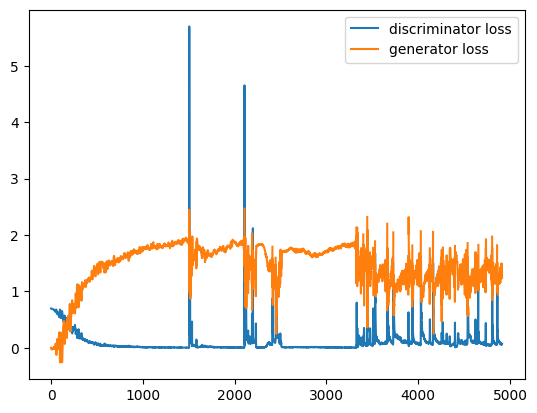

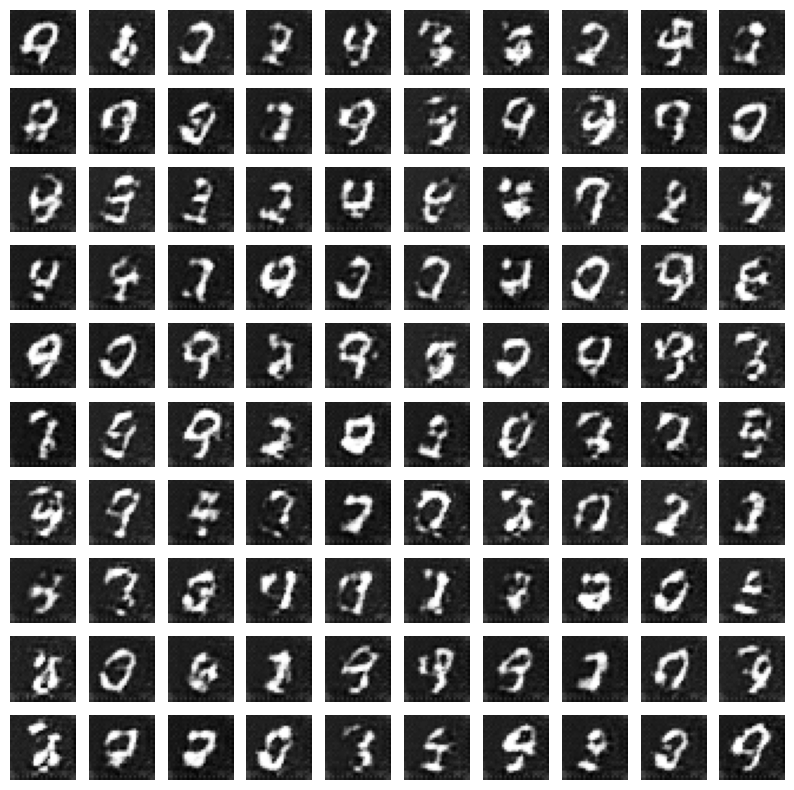

In [71]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

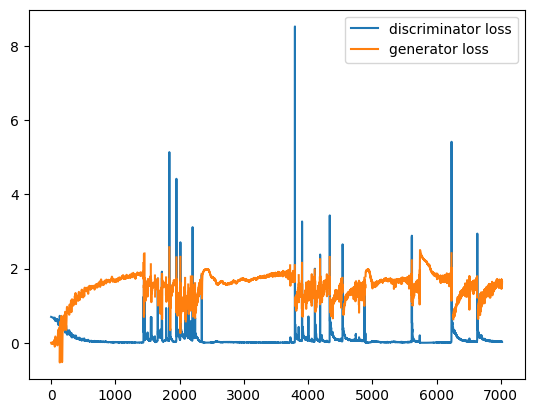

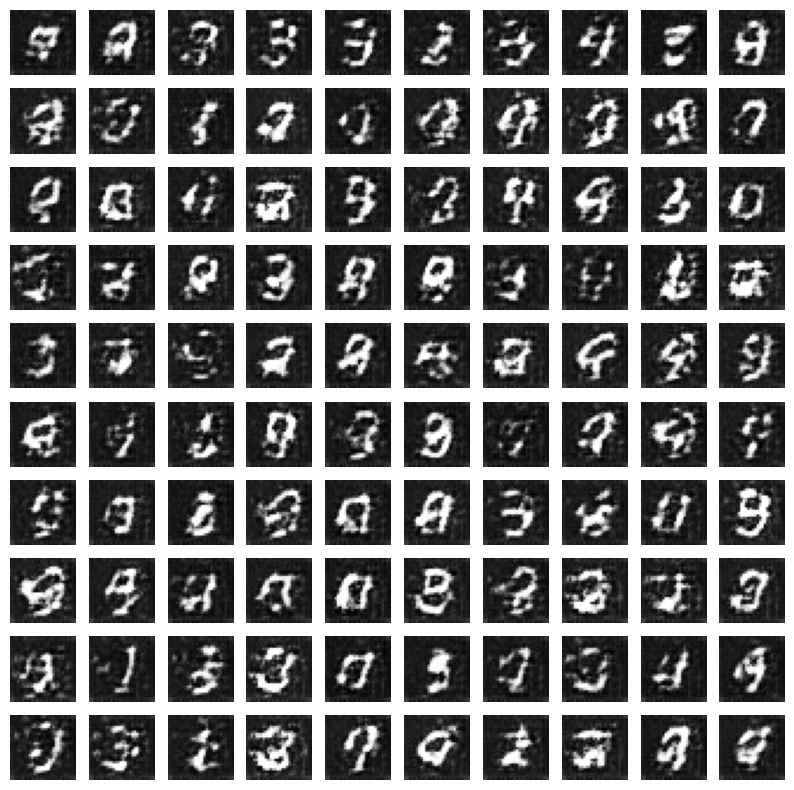

In [32]:
args['epochs'] = 30
gen_loss, disc_loss, sample = main()
plot_samples_and_losses(gen_loss, disc_loss, sample)

Выводы из работы:

Можно заметить, что во втором случае качество генерации получилось намного хуже, если убрать сигмоиду генерация получилась лучше, но видим явный мод коллпас. Конечно, и с сходимостью есть проблемы

Поэтому я решила попробовать обучить большее количество эпох, наблюдаем, что картинки стали получше, конечно, еще не такие как в первом случае.

Поэтому вывод сходимость мы наблюдаем в первом случае и лучшую генерацию тоже, тогда обоснование применения именно такого обучения присутствует:)